# Fluxo optico

Fluxo óptico é um algoritmo de visão computacional que, em poucas palavras, analisa o movimento dos pixels de um frame para outro. Como tal, é particularmente útil onde você tem movimento de fundo que não permite o uso de outros métodos. É um dos algoritmos de visão computacional mais rápidos de configurar, embora seja bastante custoso em termos computacionais.


### Função calcOpticalFlowFarneback()

Computar um fluxo ótico denso usando o algoritmo de Gunnar Ferneback's

**cv2.calcOpticalFlowFarneback(prev, next, flow, pyr_scale, levels, winsize, iterations, poly_n, poly_sigma, flags)**

* Parâmetros:
    1. **prev** = frame de entrada
    2. **next** = segundo frame do mesmo tamanho que o **prev**
    3. **flow** = computa o fluxo da imagem que tem o mesmo tamanho do **prev**
    4. **pyr_scale** = parâmetro, especificando a escala da imagem (<1) para construir pirâmides para cada imagem; pyr_scale = 0.5 significa uma pirâmide clássica, onde cada camada seguinte é duas vezes menor que a anterior.
    5. **levels** = número de camadas da pirâmide incluindo a imagem inicial; níveis = 1 significa que nenhuma camada extra é criada e apenas as imagens originais são usadas.
    6. **winsize** = tamanho médio da janela; valores maiores aumentam a robustez do algoritmo para ruído de imagem e fornecem mais chances de detecção de movimento rápido, mas geram mais campo de movimento borrado.
    7.  **interations** = número de interações do algoritmo de cada level da pirâmede.
    8.  **poly_n** = tamanho da vizinhança do pixel usado para encontrar a expansão polinomial em cada pixel; valores maiores significam que a imagem será aproximada com superfícies mais suaves, gerando algoritmo mais robusto e campo de movimento mais borrado, normalmente poly_n = 5 ou 7.
    9.  **poly_sigma** = desvio padrão do Gaussiano que é usado para suavizar as derivadas usadas como base para a expansão polinomial; para poly_n = 5, você pode definir poly_sigma = 1,1, para poly_n = 7, um bom valor seria poly_sigma = 1,5.
    10.  **flags** = operações de fluxo
         * **OPTFLOW_USE_INITIAL_FLOW** usa o fluxo de entrada como uma aproximação de fluxo inicial.
         * **OPTFLOW_FARNEBACK_GAUSSIAN** usa o filtro Gaussiano do tamanho da janela em vez de um filtro de caixa do mesmo tamanho para estimativa de fluxo ótico; geralmente, esta opção fornece um fluxo mais preciso do que com um filtro de caixa, ao custo de uma velocidade menor; normalmente, o tamanho da caixa para uma janela Gaussiana deve ser definido com um valor maior para atingir o mesmo nível de robustez.

https://docs.opencv.org/3.0-beta/modules/video/doc/motion_analysis_and_object_tracking.html#calcopticalflowfarneback

#### Resumo do Algoritmo:

O algoritmo Farneback gera uma pirâmide de imagens, onde cada nível possui uma resolução inferior em relação ao nível anterior. Quando você seleciona um nível de pirâmide maior que 1, o algoritmo pode rastrear os pontos em vários níveis de resolução, começando no nível mais baixo. Aumentar o número de níveis de pirâmide permite que o algoritmo trate de maiores deslocamentos de pontos entre quadros. No entanto, o número de cálculos também aumenta. O diagrama mostra uma pirâmide de imagens com três níveis.

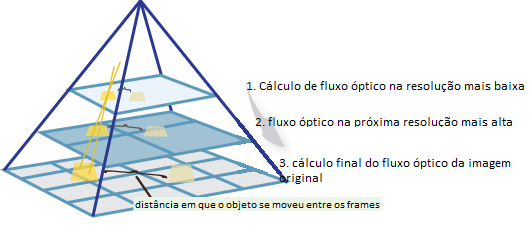


O rastreamento começa no nível de resolução mais baixo e continua até a convergência. Os locais de pontos detectados em um nível são propagados como pontos-chave para o nível seguinte. Desta forma, o algoritmo refina o rastreamento com cada nível. A decomposição da pirâmide permite que o algoritmo lide com grandes movimentos de pixel, que podem ser distâncias maiores que o tamanho da vizinhança.

In [1]:
#Bibliotecas
import numpy as np
import cv2

#Captacao da imagem
cap = cv2.VideoCapture(0)

#Lendo o primeiro frame
ret, first_frame  = cap.read()
prev_gray = cv2.cvtColor(first_frame , cv2.COLOR_BGR2GRAY)

# Criar uma mascara no primeiro frame
mask = np.zeros_like(first_frame)

# Seta a imagem com saturacao no max 
mask[..., 1] = 255

while True:    
    ret, frame = cap.read()    
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    
    flow = cv2.calcOpticalFlowFarneback(prev_gray, 
                                        gray, 
                                        None, 
                                        pyr_scale = 0.5, 
                                        levels = 3, 
                                        winsize = 15, 
                                        iterations = 3, 
                                        poly_n = 5, 
                                        poly_sigma = 1.1, 
                                        flags = 0)
    
    # Computar a magnitude e ang do optical flow dos vetores 2D    
    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    #print(magnitude)
    #print(angle)
    
    #Setar o hue de acordo com o fluxo optico    
    mask[..., 0] = angle * 180 / np.pi / 2    
    
    # Setar a imagem de acordo com a magnitude di fluxo optico (nomarlizado)    
    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
    
    #Converter HSV para BGR    
    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

    # Soma ponderada
    dense_flow = cv2.addWeighted(frame, 1,rgb, 2, 0)    
    
    cv2.imshow("Dense optical flow", dense_flow)
    prev_gray = gray    
    if cv2.waitKey(10) & 0xFF == ord('q'):        
        break
        
cap.release()
cv2.destroyAllWindows()
